In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
drugbank_input = Chem.SDMolSupplier('../data/drugbank.sdf')
drugbank = [m for m in drugbank_input if m]

# Hashed fingerprints
A vector of binary values representing the presence of fragments in a molecule, much like structural keys.
The main difference is how they are created. The bits do not represent a pre-selected set of strucural patterns, but are generated algorithmically. This removes the burden of manual feature selection and allows for much greater generality, at the price of reduced interpretability.

more info:

https://docs.chemaxon.com/display/docs/Chemical+Hashed+Fingerprint

http://www.daylight.com/dayhtml/doc/theory/theory.finger.html

## Morgan fingerprints
Frequently used, they are the vanilla flavor of structural fingerprints.

https://docs.chemaxon.com/display/docs/Extended+Connectivity+Fingerprint+ECFP

In [12]:
from rdkit.Chem import AllChem
morgan_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=512) for m in drugbank]

## Pattern analysis of DrugBank
### Fingerprint density

In [15]:
fp_default_length = morgan_fps[0].GetNumBits()
fp_default_length

512

In [24]:
on_bit_counts = [len(fp.GetOnBits()) for fp in morgan_fps]
sum(on_bit_counts) / len(on_bit_counts)

38.89127988748242

... so, average fp density in drugbank for Morgan fp with radius of 2 and size of 512 is cca 39 bits set to true on average. What if we double the fingerprint size?

In [25]:
morgan_fps_1024 = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in drugbank]
on_bit_counts = [len(fp.GetOnBits()) for fp in morgan_fps_1024]
sum(on_bit_counts) / len(on_bit_counts)

39.79535864978903

even though we doubled the fingerprint size, we have very similar average amounts of bits set to true - meaning that with all other things are equal, doubling the fingerprint size means roughly halving the fingerprint density. Less dense fingerprints have lesser amount of bit collision (and thus higher 'resolution'), but they also tend to be harder to store and process. Let's do a very bad fingerprint of size just 10:

In [26]:
morgan_fps_10 = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=10) for m in drugbank]
on_bit_counts = [len(fp.GetOnBits()) for fp in morgan_fps_10]
sum(on_bit_counts) / len(on_bit_counts)

9.50632911392405

... on average, 9.5 bits set to true on 10 bit fingerprint - it's a bit collision fiesta! Of course, such a fingerprint is useless. Too large hashed fingerprints are equally useless - once their size exceeds the count of all possible fragments (with a radius 2 in this case), you might as well use a structural key. Not to mention the size! 

In [30]:
bit_aggregation = [0]*fp_default_length
for fp in morgan_fps:
    for bit in fp.GetOnBits():
        bit_aggregation[bit] += 1
least_set_amount = min(bit_aggregation)
least_set_bit = bit_aggregation.index(least_set_amount)
most_set_amount = max(bit_aggregation)
most_set_bit = bit_aggregation.index(most_set_amount)
print(least_set_bit, least_set_amount)
print(most_set_bit, most_set_amount)

174 96
356 5667


let's try to find the patterns behind the most frequent on bit:

In [61]:
def bit2smiles(mol, bit):
    bitinfo = {}
    AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512, bitInfo=bitinfo)
    fragments = set()
    for hit, radius in bitinfo.get(bit, []):
        if radius > 0:
            hit_atoms = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, hit)
            submol = Chem.PathToSubmol(mol, hit_atoms)
            fragment_smiles = Chem.MolToSmiles(submol)
        else:
            fragment_smiles = mol.GetAtomWithIdx(hit).GetSymbol()
        fragments.add(fragment_smiles)
    return fragments

In [67]:
def explain_bit(molecules, bit):
    fragments = {}
    for mol in molecules:
        for fragment in bit2smiles(mol, bit):
            fragments[fragment] = fragments.get(fragment, 0) + 1
    return fragments

In [68]:
explain_bit(drugbank, 356)

{'C': 5638,
 'C=CCC(C)[NH3+]': 2,
 'C=Cc(cc)nc': 1,
 'C=Cc(cc)sc': 2,
 'C=Cc(n)n': 1,
 'C=NC(N)=NC': 2,
 'CC(=O)NC(C)C': 8,
 'CC(C)(C)CC(C)(C)O': 1,
 'CC(C)(c)CC[NH3+]': 1,
 'CC(C)=CC(C)O': 1,
 'CC(C)CC(C)N': 1,
 'CC(C)CC(C)O': 1,
 'CC(C)O': 63,
 'CC(N)C(=O)N(C)C': 1,
 'CC(O)C(C)C(c)O': 1,
 'CCC(C)C(=O)O': 1,
 'CCC(CC)C(C)C': 1,
 'CCC(CN)NC': 1,
 'CCC(O)C(C)N': 3,
 'CCCC(C)N': 8,
 'CCSC(C)N': 1,
 'CCc': 1,
 'CN(c)C(=O)C(C)(C)N': 1,
 'CP(=O)(O)OP(=O)(O)O': 3,
 'Ca': 1,
 'cCC': 4,
 'cN=C(CN)CO': 1,
 'cNC(=O)C(C)N': 1,
 'cc(-c)sc(c)Br': 1,
 'cc(C)c(C(C)=O)c(c)O': 1,
 'cc(C)c(C(N)=O)c(c)N': 1,
 'cc(C)c[n+](c)C': 10,
 'cc(C)o': 1,
 'cc(N)nc(c)O': 1,
 'cc(c)-c(c(c)[nH])c(c)[nH]': 1,
 'cc(c)C(CC)(C(C)=O)c(c)c': 1,
 'cc(c)C(Cc)c(c)n': 1,
 'cc(c)O[Bi](O)O': 1,
 'cc(c)nc([nH])N': 1,
 'cc(n)[O-]': 2,
 'ccc(-c(c)c)c(-c)n': 2,
 'ccc(Br)c(c)O': 2,
 'ccc(C)c(c)N': 1,
 'ccc(OC)c(c)C': 4,
 'ccc(OC)c(c)O': 42,
 'ccc(OC)c(c)c': 1,
 'ccc(Oc)c(c)N': 2,
 'ccc(c(c)s)[n+](c)[O-]': 1,
 'cccc(C)n': 1,
 'cccsc':

In [69]:
explain_bit(drugbank, 174)

{'C=C(C)CC(C)Cl': 1,
 'C=C(C)Cc(c)c': 1,
 'C=C(C)S[Mo](=O)([O-])S': 1,
 'C=CCC(C)C': 3,
 'C=N(C)~[Co+](O)(N(C)C)(~N(=C)C)(~N(=C)C)~n(c)c': 1,
 'C=NCC(C)C': 1,
 'C=[N+](C)CC': 1,
 'CC(=O)N(C)C(C)C': 1,
 'CC(=O)OC(C)C': 2,
 'CC(C)(C)O': 1,
 'CC(C)C(C(N)=O)C(c)O': 1,
 'CC(C)OCn': 2,
 'CC(N)C(F)(F)CN': 1,
 'CC(O)CCN': 1,
 'CC(S)=NC(C)C': 1,
 'CC(c)=NO': 1,
 'CC=CCO': 3,
 'CC=CN(C)C': 1,
 'CCC(N)C(=O)O': 1,
 'CCN(CC)C(C)C': 4,
 'CCOP(N)(N)=O': 1,
 'CN(C)C(=O)C(c)(c)C': 1,
 'COC(C(C)C)C(C)C': 1,
 'COC(C(C)O)C(O)O': 1,
 'COC(CO)C(C)O': 1,
 'COCC(N)=O': 2,
 'CSC(=C(C)N)C(C)C': 3,
 'CSCC(F)(F)F': 1,
 'C[N+](=O)[O-]': 2,
 'N#CN': 1,
 'cC(=O)CN(C)C': 2,
 'cC(C)=NO': 1,
 'cOC(C(C)O)C(C)(C)c': 2,
 'c[nH]c(=CC)c(c)C': 1,
 'cc(C)c(F)c(c)F': 1,
 'cc(N)cc(c)c': 11,
 'cc(O)c(c(c)c)n(c)C': 3,
 'cc(c)C(CC)C(C)N': 1,
 'cc(c)C(Cc)C(C)N': 2,
 'cc(c)S(=O)(=O)N(C)C': 7,
 'cc(n)C(=NC)NC': 1,
 'cc(n)nc(C)n': 2,
 'ccc(B(O)O)c(c)C': 2,
 'ccc(C(N)=O)c(c)C': 7,
 'ccc(C(N)=O)c(c)[NH3+]': 2,
 'ccc(Cc)n(c)C': 1,
 'ccc(

In conclusion, this particular fingerprint covers all possible fragments up to radius of 2 atoms, and compresses the information about their presence into 512 bits. Therefore, one bit can represent many different fragments. Determining the structures of the actual fragment responsible for a given set bit is possible, but it takes a bit of work. 

## Similarity search
Done exactly the same way as on the structural key notebook from the last lecture.

In [74]:
from rdkit import DataStructs
salicylica = Chem.MolFromSmiles("c1ccc(c(c1)C(=O)O)O")
salicylica_fp = AllChem.GetMorganFingerprintAsBitVect(salicylica, 2, nBits=512)
salicylica_similarities = [DataStructs.FingerprintSimilarity(salicylica_fp, mol_fp)
                           for mol_fp in morgan_fps]
len(salicylica_similarities), min(salicylica_similarities), max(salicylica_similarities)

(7110, 0.0, 1.0)

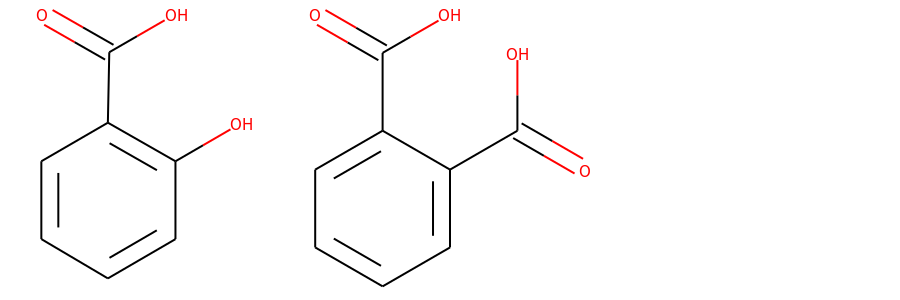

In [83]:
match_indexes = [i for i, similarity in enumerate(salicylica_similarities) if similarity >= 0.7]
Draw.MolsToGridImage([drugbank[i] for i in match_indexes[:9]], subImgSize=(300, 300))

## Diversity picking
Fingerprints are also sometimes used to pick diverse subsets of molecules out of a bigger set. Drugbank has over 7000 molecules, let's say we want a set of 20 molecules from Drugbank that best represents its chemical variety.

In [90]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

def distance_function(index1, index2, *args, fingerprints=morgan_fps):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1], fingerprints[index2])

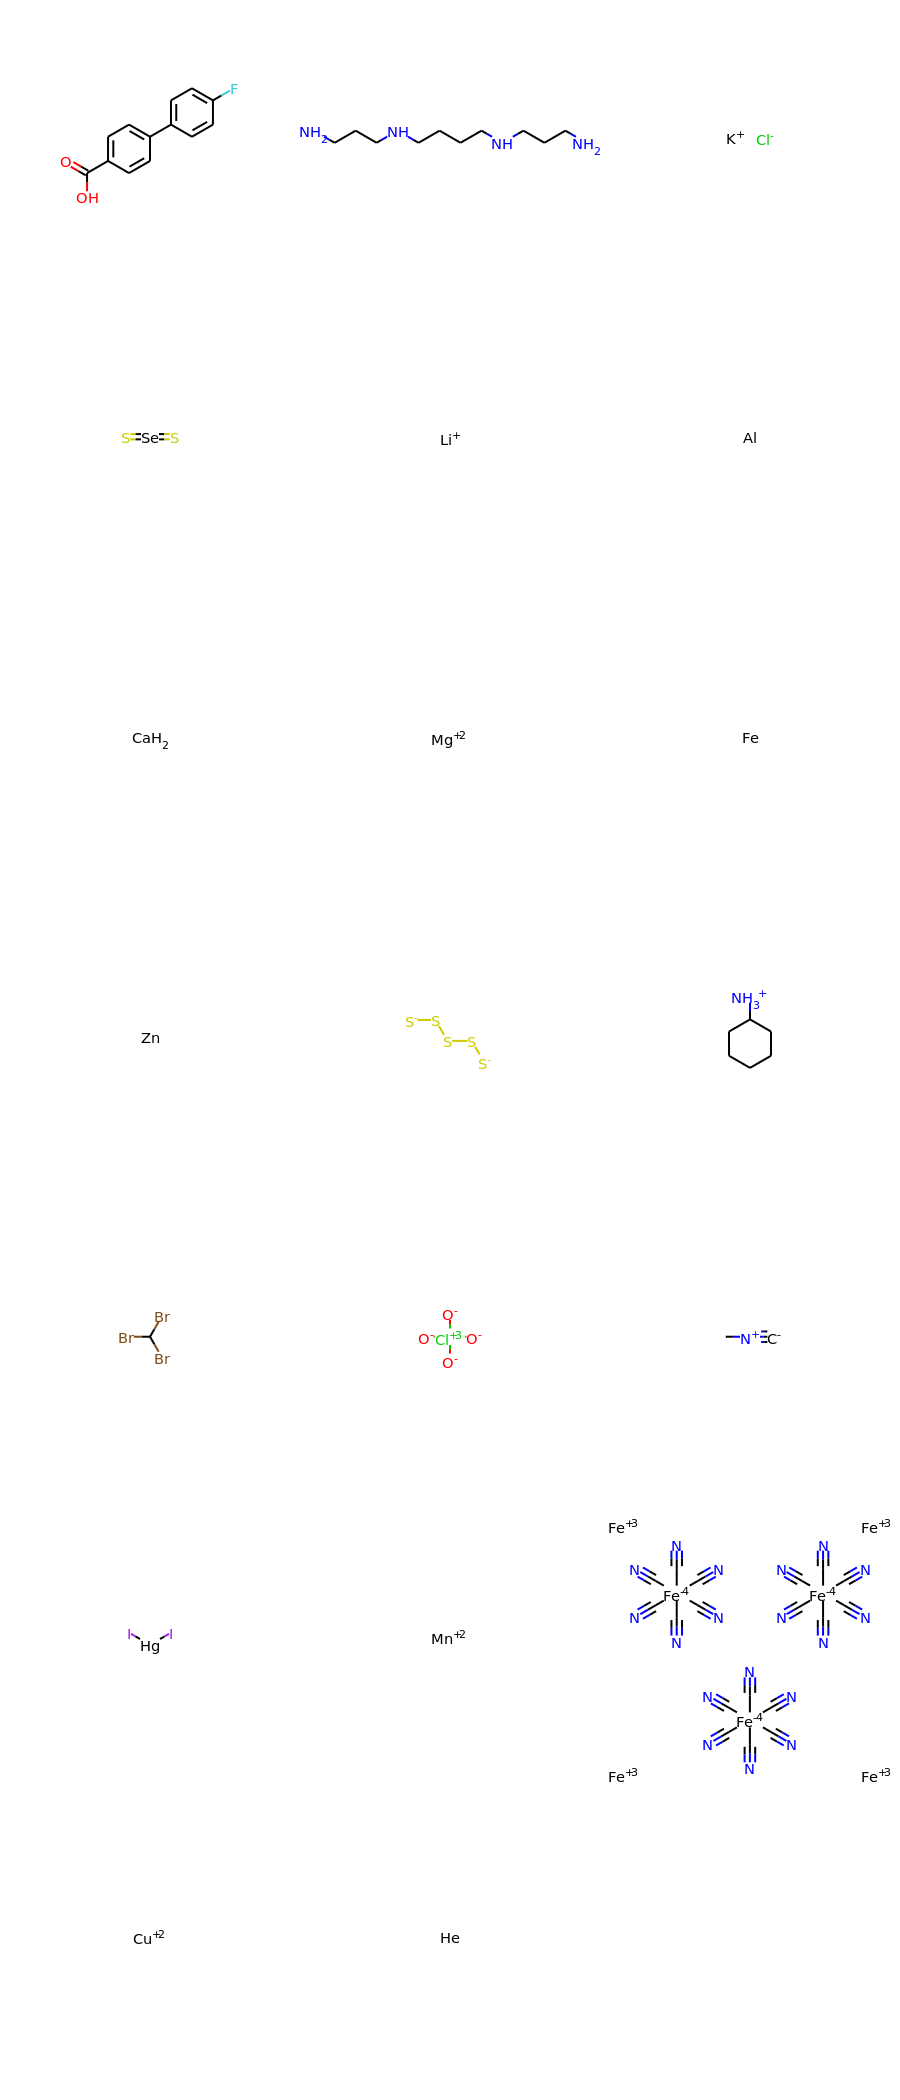

In [91]:
picker = MaxMinPicker()
picked = picker.LazyPick(distance_function, len(morgan_fps), 20, seed=666)
Draw.MolsToGridImage([drugbank[i] for i in picked], subImgSize=(300, 300))